In [1]:
#Importing essentials
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import normalize


In [2]:
#importing from experimental file
# Num Nuc  A   N   Z        E        E/A     dE     Eval    S1n     dS1n  Eval    
# 0   1    2   3   4        5        6       7      8       9       10    11

#S1p     dS1p  Eval    S2n     dS2n  Eval    S2p     dS2p  Eval
#12      13    14      15      16    17      18      19    20

N_exp  = np.genfromtxt('EXPERIMENT_AME2016.dat',usecols=3) #Number of neutrons
Z_exp  = np.genfromtxt('EXPERIMENT_AME2016.dat',usecols=4) #Number of protons
X_exp  = np.transpose(np.stack((Z_exp,N_exp)))
A_exp  = N_exp+Z_exp # Total number of Nucleons

# Difference between the experimental binding energy and the Liquid drop model
y_exp  = -np.genfromtxt('EXPERIMENT_AME2016.dat',usecols=5)
dy_exp = -np.genfromtxt('EXPERIMENT_AME2016.dat',usecols=7)

S_p_exp  = -np.genfromtxt('EXPERIMENT_AME2016.dat',usecols=12)
S_2p_exp = -np.genfromtxt('EXPERIMENT_AME2016.dat',usecols=18)

S_n_exp =-np.genfromtxt('EXPERIMENT_AME2016.dat',usecols=9)
S_2n_exp=-np.genfromtxt('EXPERIMENT_AME2016.dat',usecols=15)

X_exp     = np.transpose(np.stack((Z_exp,   N_exp,  A_exp,  y_exp)))

y_exp_d={}
S_n_exp_d={}
S_2n_exp_d={}

for i in range(0,len(N_exp)):
    y_exp_d[Z_exp[i], N_exp[i]]=y_exp[i]
    S_n_exp_d[Z_exp[i], N_exp[i]]=S_n_exp[i]
    S_2n_exp_d[Z_exp[i], N_exp[i]]=S_2n_exp[i]

In [5]:
#SKMS importing relevent data
#Symbol Z  N A Binding_Energy_(MeV)  S_p_(MeV)  S_{2p}_(MeV) S_n_(MeV)  S_{2n}_(MeV) Q_{alpha}_(MeV)       
#0      1  2 3 4                     5          6            7          8            9

Z_SKMS    = np.genfromtxt('SKMS_all_nuclei-new.dat',usecols=1) #Number of protons
N_SKMS    = np.genfromtxt('SKMS_all_nuclei-new.dat',usecols=2) #Number of neutrons
A_SKMS    = N_SKMS+Z_SKMS                                      #Total number of Nucleons
y_SKMS    = -np.genfromtxt('SKMS_all_nuclei-new.dat',usecols=4)

S_p_SKMS  = -np.genfromtxt('SKMS_all_nuclei-new.dat',usecols=5)
S_2p_SKMS = -np.genfromtxt('SKMS_all_nuclei-new.dat',usecols=6)

S_n_SKMS  = -np.genfromtxt('SKMS_all_nuclei-new.dat',usecols=7)
S_2n_SKMS = -np.genfromtxt('SKMS_all_nuclei-new.dat',usecols=8)

Q_SKMS    = -np.genfromtxt('SKMS_all_nuclei-new.dat',usecols=9)

S_p_SKMS  = np.where(np.isnan(S_p_SKMS), 0, S_p_SKMS)
S_2p_SKMS = np.where(np.isnan(S_2p_SKMS), 0, S_2p_SKMS)

S_n_SKMS  = np.where(np.isnan(S_n_SKMS), 0, S_n_SKMS)
S_2n_SKMS = np.where(np.isnan(S_2n_SKMS), 0, S_2n_SKMS)

Q_SKMS=np.where(np.isnan(Q_SKMS), 0, Q_SKMS)

X_SKMS    = np.transpose(np.stack((Z_SKMS, N_SKMS, A_SKMS, y_SKMS, S_p_SKMS, S_2p_SKMS, S_n_SKMS, S_2n_SKMS, Q_SKMS)))
NZ_SKMS   = np.transpose(np.stack((Z_SKMS, N_SKMS)))

y_SKMS_d    ={}
S_p_SKMS_d  ={}
S_2p_SKMS_d ={}

S_n_SKMS_d  ={}
S_2n_SKMS_d ={}

Q_SKMS_d    ={}

for i in range(0,len(X_SKMS)):
    y_SKMS_d[Z_SKMS[i], N_SKMS[i]]=y_SKMS[i]
    S_p_SKMS_d[Z_SKMS[i], N_SKMS[i]]=S_p_SKMS[i]
    S_2p_SKMS_d[Z_SKMS[i], N_SKMS[i]]=S_2p_SKMS[i]
    S_n_SKMS_d[Z_SKMS[i], N_SKMS[i]]=S_n_SKMS[i]
    S_2n_SKMS_d[Z_SKMS[i], N_SKMS[i]]=S_2n_SKMS[i]
    Q_SKMS_d[Z_SKMS[i], N_SKMS[i]]=Q_SKMS[i]


# Get current size
fig_size = plt.rcParams["figure.figsize"]
# Prints: [8.0, 6.0]
#print ("Current size:", fig_size)
# Set figure width to 12 and height to 9
fig_size[0] = 15
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size


In [102]:
def ki(exp, theo):
    ki_2=0
    
    for i in range(0, len(exp)):
        ki_2=ki_2+(exp[i]-theo[i])**2

    return ki_2

In [8]:
y_matSKMS_d  ={}

Q_matSKMS_d  ={}
y_matexp_d   ={}
Q_matexp_d   ={}

N_mat        =[]
Z_mat        =[]
diff_mat     =[]
Q_matSKMS    =[]
Q_matexp     =[]

for n in range(0, 177+1):
    for z in range(0, 118+1):
        try:
            if y_exp_d[z,n]!=0 and y_SKMS_d[z,n]!=0:
                y_matSKMS_d[z,n]=y_SKMS_d[z,n]
                Q_matSKMS_d[z,n]=Q_SKMS_d[z,n]
                
                y_matexp_d[z,n] =y_exp_d[z,n]
                #Q_matexp_d[z,n]=Q_exp_d[z,n]
            
                N_mat.append(n)
                Z_mat.append(z)
                diff_mat.append(y_exp_d[z,n]-y_SKMS_d[z,n])
                Q_matSKMS.append(Q_SKMS_d[z,n])
                #Q_matexp.append(Q_exp_d[z,n])
                
                
        except KeyError:
            continue


                
                
S_n_matexp_d={} 
S_n_matSKMS_d={}
S_n_matexp=[] 
S_n_matSKMS=[]

S_p_matSKMS=[]

N_S_n_mat=[]
Z_S_n_mat=[]

Q_S_n_matSKMS_d={}
diff_S_n_mat=[]
Q_S_n_matSKMS=[]


for n in range(0, 177+1):
    for z in range(0, 118+1):
        try:
            if S_n_exp_d[z,n]!=0 and S_n_SKMS_d[z,n]!=0:
                S_n_matexp_d[z,n] =S_n_exp_d[z,n]
                S_n_matSKMS_d[z,n]=S_n_SKMS_d[z,n]
                S_n_matexp.append(S_n_exp_d[z,n]) 
                S_n_matSKMS.append(S_n_SKMS_d[z,n])
                
                S_p_matSKMS.append(S_p_SKMS_d[z,n])
                
                N_S_n_mat.append(n)
                Z_S_n_mat.append(z)
                
                Q_S_n_matSKMS_d[z,n]=Q_SKMS_d[z,n]
                
                diff_S_n_mat.append(y_exp_d[z,n]-y_SKMS_d[z,n])
                Q_S_n_matSKMS.append(Q_SKMS_d[z,n])
                
        except KeyError:
            continue
            

N_nomatSKMS=[]
Z_nomatSKMS=[]
y_nomatSKMS=[]
Q_nomatSKMS=[]
S_n_nomatSKMS=[]
S_p_nomatSKMS=[]


for n in range(0, 301):
    for z in range(0, 121):
        try:
            #print('y_exp_d[n, z]')
            y_exp_d[z,n]
            
        except KeyError:
            try:
                #print('if y_SKMS_d[n,z]!=0:')
                if y_SKMS_d[z,n]!=0:
                    #print('N_nomatSKMS=n')
                    N_nomatSKMS.append(n)
                    Z_nomatSKMS.append(z)
                    y_nomatSKMS.append(y_SKMS_d[z,n])
                    Q_nomatSKMS.append(Q_SKMS_d[z,n])
                    S_n_nomatSKMS.append(S_n_SKMS_d[z,n])
                    S_p_nomatSKMS.append(S_p_SKMS_d[z,n])
                    
            except KeyError:
                #print('continue')
                continue
                
        continue
                
    
            
            
  
print(np.shape(Z_nomatSKMS))
print(np.shape(N_nomatSKMS))
print(np.shape(y_nomatSKMS))
print(np.shape(Q_nomatSKMS))
 

(5430,)
(5430,)
(5430,)
(5430,)


In [9]:
#X_SKMS    = np.transpose(np.stack((Z_SKMS, N_SKMS, A_SKMS, y_SKMS, S_p_SKMS, S_2p_SKMS, S_n_SKMS, S_2n_SKMS, Q_SKMS)))
ndrip_SKMS=[]
zdep_SKMS =[]

zdrip_SKMS=[]
ndep_SKMS =[]


for i in range(0,len(X_SKMS)):
    try:
        if X_SKMS[i-1][0] != X_SKMS[i][0]:
            #print(X_SKMS[i][0]) 
            zdrip_SKMS.append(X_SKMS[i][0])
            ndep_SKMS.append(X_SKMS[i][1])
    
    except IndexError:
        #print('except', i,  X_SKMS[i][0])
        zdrip_SKMS.append(X_SKMS[i-1][0])
        ndep_SKMS.append(X_SKMS[i-1][1])
             
for i in range(2,len(X_SKMS)):
    try:
        if X_SKMS[i+1][0] != X_SKMS[i][0]:
            #print(X_SKMS[i][0]) 
            ndrip_SKMS.append(X_SKMS[i][1])
            zdep_SKMS.append(X_SKMS[i][0])
        
    except IndexError:
        #print('except', i,  X_SKMS[i][0])
        ndrip_SKMS.append(X_SKMS[i][1])
        zdep_SKMS.append(X_SKMS[i][0])
    
zdripndep_SKMS = np.transpose(np.stack((zdrip_SKMS,ndep_SKMS )))
ndripzdep_SKMS = np.transpose(np.stack((ndrip_SKMS,zdep_SKMS )))




allvals=[]
for i in range(0,118):
    for n in range(int(ndep_SKMS[i])-30, int(ndrip_SKMS[i])+30):
        allvals.append([zdep_SKMS[i], n])

allvals=np.array(allvals) 
allvals=np.transpose(allvals)

In [10]:
ndrip_exp=[]
zdep_exp=[]

zdrip_exp=[]
ndep_exp=[]


for i in range(0,len(X_exp)):
    try:
        if X_exp[i-1][0] != X_exp[i][0]:
            #print(X_SKMS[i][0]) 
            zdrip_exp.append(X_exp[i][0])
            ndep_exp.append(X_exp[i][1])
    
    except IndexError:
        #print('except', i,  X_SKMS[i][0])
        zdrip_exp.append(X_exp[i-1][0])
        ndep_exp.append(X_exp[i-1][1])
             
for i in range(2,len(X_exp)):
    try:
        if X_exp[i+1][0] != X_exp[i][0]:
            #print(X_SKMS[i][0]) 
            ndrip_exp.append(X_exp[i][1])
            zdep_exp.append(X_exp[i][0])
        
    except IndexError:
        #print('except', i,  X_SKMS[i][0])
        ndrip_exp.append(X_exp[i][1])
        zdep_exp.append(X_exp[i][0])
    
    
    
zdripndep_exp = np.transpose(np.stack((zdrip_exp,ndep_exp )))
ndripzdep_exp = np.transpose(np.stack((ndrip_exp,zdep_exp )))


#plt.plot(np.transpose(ndripzdep_exp)[0], np.transpose(ndripzdep_exp)[1],label='python neutron drip line')
#plt.plot(np.transpose(zdripndep_exp)[1], np.transpose(zdripndep_exp)[0],label='python proton drip line')
#plt.plot(np.transpose(ndripzdep_SKMS)[0][0:-1], np.transpose(ndripzdep_SKMS)[1][0:-1],label='python neutron drip line')
#plt.plot(np.transpose(zdripndep_SKMS)[1][0:-1], np.transpose(zdripndep_SKMS)[0][0:-1],label='python proton drip line')
#plt.plot(allvals[1], allvals[0], 'o', markersize=1)
#plt.plot(N_exp,  Z_exp, 'o', markersize=2, label='experimental')
#plt.ylabel('Proton  #')
#plt.xlabel('Neutron #')
#plt.legend()
#plt.show()

In [11]:
NZ_mat=np.transpose(np.stack((Z_mat,N_mat)))
NZ_mat=np.array(NZ_mat)

rf_NZ=RandomForestRegressor(n_estimators=1000)

X_train, X_test, y_train, y_test = train_test_split(NZ_mat, diff_mat, test_size =0.25) #, random_state=42 )
rf_NZ.fit(X_train,y_train)
print(rf_NZ.score(X_train,y_train))
print(rf_NZ.score(X_test,y_test))

diff_NZ=rf_NZ.predict(NZ_SKMS)

0.9991621470876727
0.9936503004628274


In [12]:
NZQ_mat=np.transpose(np.stack((Z_mat,N_mat, Q_matSKMS)))
NZQ_mat=np.array(NZQ_mat)

NZQ_SKMS=np.transpose(np.stack((Z_SKMS,N_SKMS, Q_SKMS)))
NZQ_SKMS=np.array(NZQ_SKMS)

                    
rf_NZQ=RandomForestRegressor(n_estimators=1000)
X_train, X_test, y_train, y_test = train_test_split(NZQ_mat, diff_mat, test_size =0.25) #, random_state=42 )
rf_NZQ.fit(X_train,y_train)
print(rf_NZQ.score(X_train,y_train))
print(rf_NZQ.score(X_test,y_test))

diff_NZQ=rf_NZQ.predict(NZQ_SKMS)


0.9981910238957152
0.987275709807437


In [123]:
ZQ_mat=np.transpose(np.stack((Z_mat, Q_matSKMS)))
ZQ_mat=np.array(ZQ_mat)

ZQ_SKMS=np.transpose(np.stack((Z_SKMS, Q_SKMS)))
ZQ_SKMS=np.array(ZQ_SKMS)

print(np.shape(ZQ_SKMS))
print(ZQ_SKMS[0])
print(ZQ_SKMS[0][0])
print(ZQ_SKMS[0][1])

rf_ZQ=RandomForestRegressor(n_estimators=1000)
X_train, X_test, y_train, y_test = train_test_split(ZQ_mat, diff_mat, test_size =0.25) #, random_state=42 )
rf_ZQ.fit(X_train,y_train)
print(rf_ZQ.score(X_train,y_train))
print(rf_ZQ.score(X_test,y_test))

diff_ZQ=rf_ZQ.predict(ZQ_SKMS)

(8700, 2)
[2. 0.]
2.0
0.0
0.9854787753208044
0.8787309859144911


In [207]:
diff_ZQ_list=[]
diff_ZQ_list_d={}

err_list=[]
ki_2_ZQ_list=[] 
    

Sn_2n_SKMS_vals    =[] #n values for all SKMS theoretical values
Sn_SKMS_sep_2n     =[] #SKMS separation values WITHOUT ML

Sn_2n_SKMS_ml_vals =[]
Sn_SKMS_ml_sep_2n  =[] #SKMS separation values WITH ML

Sn_2n_exp_vals     =[] #n values for all Experimental values
Sn_exp_sep_2n      =[] #Experimental separation values 


     
#experimental loop
for i in range(1366,1405):
    Sn_2n_exp_vals.append(N_exp[i])
    Sn_exp_sep_2n.append(-S_2n_exp[i])
    #print('N:', N_exp[i], 'S:', -S_2n_exp[i])

#print('\n')
for i in range(1942, 2022):
    Sn_2n_SKMS_vals.append(N_SKMS[i])
    Sn_SKMS_sep_2n.append(-S_2n_SKMS[i])
    #print('N:', N_SKMS[i], 'S:', -S_2n_SKMS[i])

for i in range(0,100,1):
    #Sn_2n_SKMS_ml_vals=[]
    #Sn_SKMS_ml_sep_2n=[]

    rf_ZQ=RandomForestRegressor(n_estimators=1000)
    X_train, X_test, y_train, y_test = train_test_split(ZQ_mat, diff_mat, test_size =0.25)
    rf_ZQ.fit(X_train,y_train)
    print(i)
    #print(rf_ZQ.score(X_train,y_train))
    #print(rf_ZQ.score(X_test,y_test))
    
    
    diff_ZQ=rf_ZQ.predict(ZQ_SKMS)
    diff_ZQ_list.append(diff_ZQ)
    
    for j in range(0,len(ZQ_SKMS)):
        diff_ZQ_list_d[i, ZQ_SKMS[j][0], ZQ_SKMS[j][1] ] =diff_ZQ[j]
    
    
    ki_2_ZQ_list.append(ki(diff_mat, rf_ZQ.predict(ZQ_mat)))
    
    for n in range(45, 127):
        try:
            #finding SKMS separation values with added ml component
            y_now=y_SKMS_d[50,n]+rf_ZQ.predict([[50, Q_SKMS_d[50,n] ]])
            y_previous=y_SKMS_d[50,n-2]+rf_ZQ.predict([[50, Q_SKMS_d[50,n-2] ]])
            #appending theoretical values and their n values to lists
            Sn_2n_SKMS_ml_vals.append(n)
            Sn_SKMS_ml_sep_2n.append(y_now-y_previous)
            #print('N:', n, 'S:', y_now-y_previous)
            #print('N:', n, 'prediction:', rf.predict([[50, n]]), rf.predict([[50, n-2]]) )
            
        except KeyError:
            continue 
    err_list.append([Sn_2n_SKMS_ml_vals, Sn_SKMS_ml_sep_2n])
    Sn_2n_SKMS_ml_vals=[]
    Sn_SKMS_ml_sep_2n=[]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [208]:
#SHAPE HAS TO BE (8700, 10)

diff_ZQ_list=np.transpose(diff_ZQ_list)

print("SHAPE HAS TO BE (8700, 10)")
print(np.shape(diff_ZQ_list))
print(diff_ZQ_list[0])



print("max: ", max(diff_ZQ_list[0]))
print("mean: ", np.mean(diff_ZQ_list[0]))
print("min: ", min(diff_ZQ_list[0]))

SHAPE HAS TO BE (8700, 10)
(8700, 100)
[-5.78860413 -5.95847632 -4.9525022  -4.27198614 -4.67096661 -5.83283529
 -4.62082301 -5.70829878 -7.15061696 -5.82069041 -3.20328283 -5.88070231
 -5.88972571 -6.76333681 -5.72917474 -4.81086205 -5.89743651 -5.9513473
 -5.71883943 -5.13508724 -4.58103897 -4.76030413 -5.85867799 -4.5856621
 -4.32198661 -6.20660053 -5.86085669 -1.88171941 -5.72415605 -4.41084299
 -6.20084038 -5.92834197 -5.88613854 -7.30664103 -5.76025603 -6.61622216
 -7.33014432 -5.88613615 -6.25286157 -5.84873326 -5.87342959 -5.78083214
 -5.82762589 -5.87944986 -5.84091241 -7.53634132 -6.33967547 -4.77276614
 -4.88759194 -6.52087918 -5.83643814 -5.88573606 -6.64623425 -5.93101613
 -4.87161892 -5.92341242 -5.9279061  -5.85387242 -4.48508336 -6.17367575
 -2.61187066 -5.85875035 -4.8806919  -6.40733435 -4.53566023 -3.7822679
 -7.43894884 -5.87718131 -7.45049774 -4.68065479 -4.53907506 -5.90326542
 -5.94792035 -5.75779617 -7.50497152 -4.54948615 -7.41554748 -4.48772319
 -7.54193094 -5

In [203]:
print(NZ_SKMS[1942])
print(NZ_SKMS[2021])
print(NZ_SKMS[2022])

    

[50. 46.]
[ 50. 126.]
[51. 52.]


In [106]:
#print(diff_ZQ_list[0], "\n")
print("mean: ", np.mean(diff_ZQ_list[0]))
print("std: ", np.std(diff_ZQ_list[0]))


mean:  -5.385576712122465
std:  1.2136213898781152


In [209]:
mean_diff_ZQ=[]
max_diff_ZQ=[]
min_diff_ZQ=[]


std_diff_ZQ=[]


for i in range(0, len(diff_ZQ)):
    mean_diff_ZQ.append(np.mean(diff_ZQ_list[i]))
    max_diff_ZQ.append(max(diff_ZQ_list[i]))
    min_diff_ZQ.append(min(diff_ZQ_list[i]))
    std_diff_ZQ.append(np.std(diff_ZQ_list[i]))

In [210]:
print("shape of mean diff ZQ", np.shape(mean_diff_ZQ))
print("mean of the mean diff ZQ", np.mean(mean_diff_ZQ))
print("std of the mean diff ZQ", np.std(mean_diff_ZQ), "\n\n")


print("shape of std diff ZQ", np.shape(std_diff_ZQ))
print("mean of std diff ZQ",  np.mean(std_diff_ZQ))
print("std of std diff ZQ",  np.std(std_diff_ZQ), "\n\n")

print("shape of max diff ZQ", np.shape(max_diff_ZQ))
print("mean of the max diff ZQ", np.mean(max_diff_ZQ))
print("std of the max diff ZQ", np.std(max_diff_ZQ), "\n\n")

print("shape of min diff ZQ", np.shape(min_diff_ZQ))
print("mean of the min diff ZQ", np.mean(min_diff_ZQ))
print("std of the min diff ZQ", np.std(min_diff_ZQ), "\n\n")

print("ki_2_ZQ_list")
print(ki_2_ZQ_list) 
print("std:", np.std(ki_2_ZQ_list) )
print("mean:",  np.mean(ki_2_ZQ_list))


shape of mean diff ZQ (8700,)
mean of the mean diff ZQ 1.5773318606529922
std of the mean diff ZQ 6.729690334803441 


shape of std diff ZQ (8700,)
mean of std diff ZQ 0.43371145101541014
std of std diff ZQ 0.3818640656138253 


shape of max diff ZQ (8700,)
mean of the max diff ZQ 2.5747015749461806
std of the max diff ZQ 6.57066887253084 


shape of min diff ZQ (8700,)
mean of the min diff ZQ 0.5096540003358078
std of the min diff ZQ 6.9486200728649425 


ki_2_ZQ_list
[5788.7993351881905, 5931.59448115303, 5572.569748044176, 5252.825780752779, 5374.868405401718, 5861.125575065548, 5314.911828915206, 5407.116878636635, 5649.514128644016, 5367.4480797527885, 5686.268539598833, 5693.780300942447, 5519.533972075983, 5481.958629161343, 5711.089836658912, 5456.819465048405, 5275.072388521031, 5816.720853688807, 5583.042698653023, 5871.295088385653, 5496.000577399388, 5788.2763794765515, 5209.3520097999635, 5689.089293584635, 5525.475917676191, 5961.883370795239, 5285.334149553862, 5287.4311

(80,)


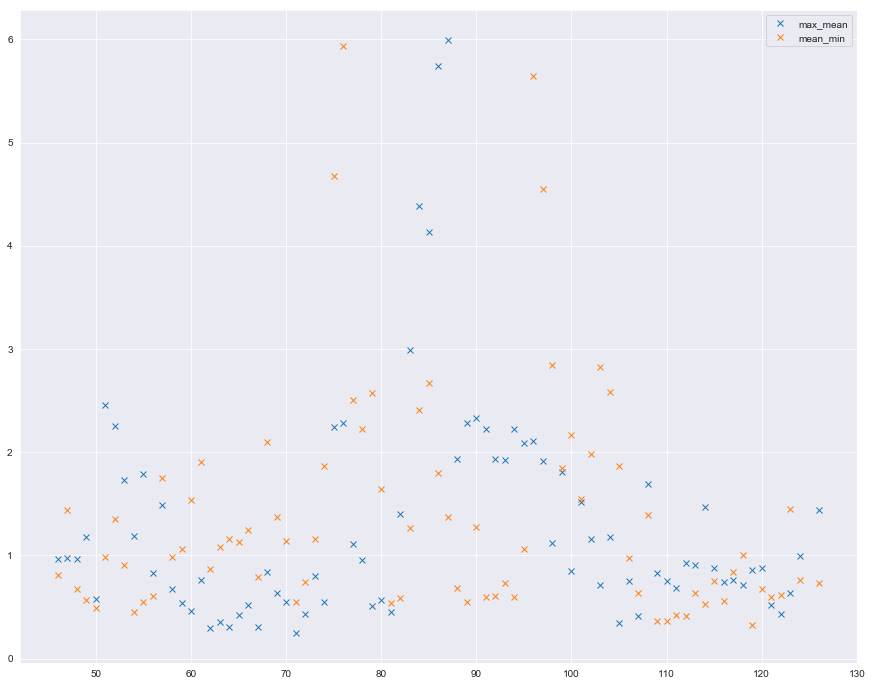

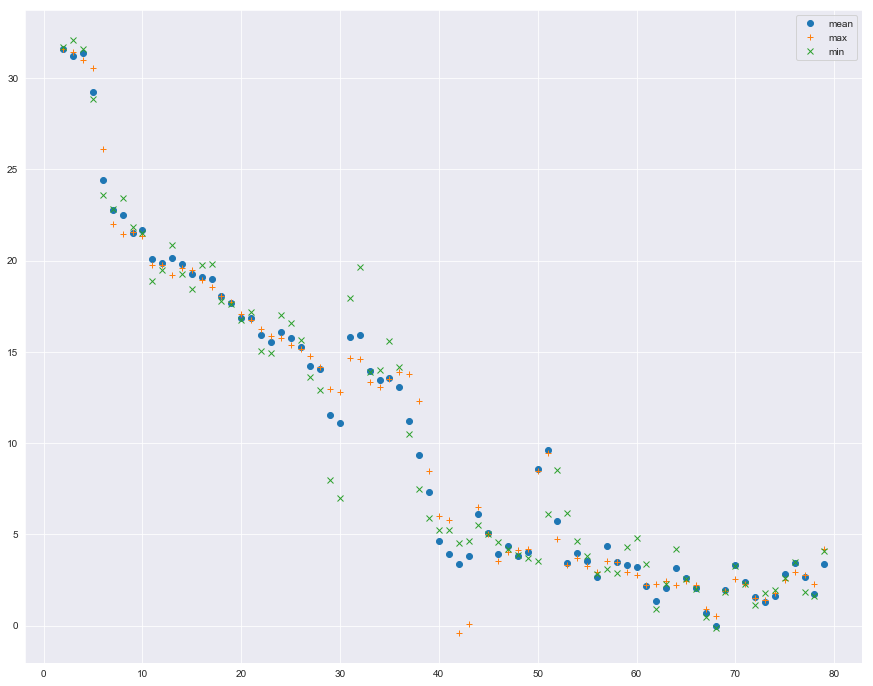

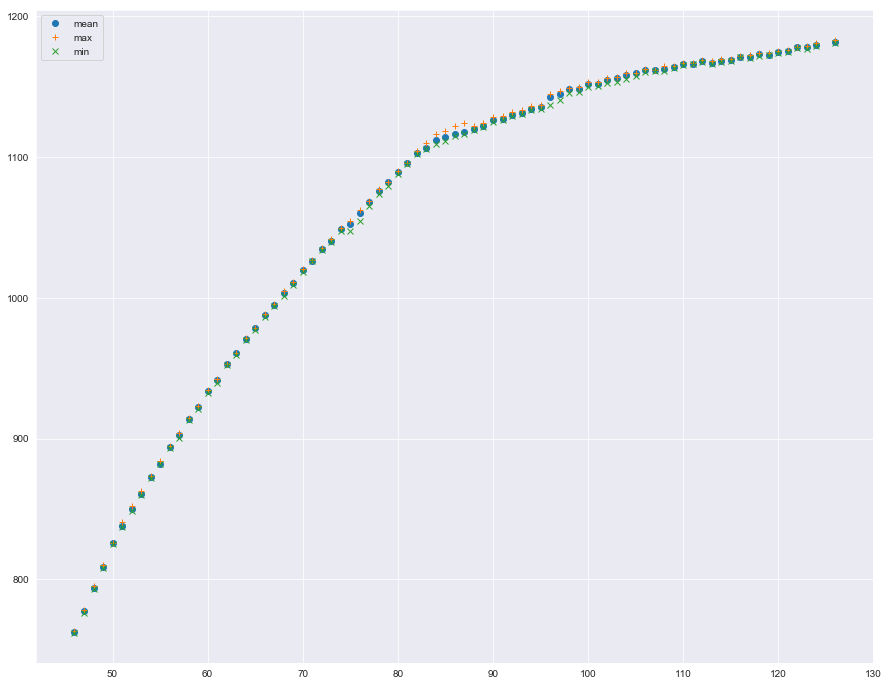

In [224]:
n_vals=[]
Sn_mean_ml=[]
Sn_max_ml=[]
Sn_min_ml=[]
Sn_exp_vals=[]

Sn_max_mean_diff=[]
Sn_mean_min_diff=[]
Sn_max_min_diff =[]
for i in range(1942, 2022):
    try:
        #print(NZ_SKMS[i][1])
        Sn_max_mean_diff.append(max_diff_ZQ[i]-mean_diff_ZQ[i])
        Sn_mean_min_diff.append(mean_diff_ZQ[i]-min_diff_ZQ[i])
        Sn_max_min_diff.append(max_diff_ZQ[i]-min_diff_ZQ[i])
        
        n_vals.append(NZ_SKMS[i][1])
        Sn_mean_ml.append(y_SKMS[i] + mean_diff_ZQ[i])
        Sn_max_ml.append(y_SKMS[i] + max_diff_ZQ[i])
        Sn_min_ml.append(y_SKMS[i] + min_diff_ZQ[i])
    
        Sn_exp_vals.append(y_exp_d[50, NZ_SKMS[i][1]])
        
        

    except KeyError:
        continue

        
print(np.shape(Sn_max_mean_diff))
plt.plot(n_vals, Sn_max_mean_diff, "x", label="max_mean")
plt.plot(n_vals, Sn_mean_min_diff, "x", label="mean_min")
#plt.plot(n_vals, Sn_max_min_diff, "x", label="max_min")
plt.legend()
plt.show()
        

Sn_sep_n=[]
Sn_mean_sep_val =[]
Sn_max_sep_val  =[]
Sn_min_sep_val  =[]
        
for i in range(2, len(n_vals)):
    Sn_sep_n.append(i)
    Sn_mean_sep_val.append(Sn_mean_ml[i]-Sn_mean_ml[i-2])
    Sn_max_sep_val.append(Sn_max_ml[i]-  Sn_max_ml[i-2])
    Sn_min_sep_val.append(Sn_min_ml[i]-  Sn_min_ml[i-2])
    
    Sn_max_mean_diff


plt.plot(Sn_sep_n, Sn_mean_sep_val, "o", label="mean")
plt.plot(Sn_sep_n, Sn_max_sep_val, "+", label="max")
plt.plot(Sn_sep_n, Sn_min_sep_val, "x", label="min")
#plt.errorbar(Sn_sep_n, Sn_mean_sep_val, yerr=Sn_min_sep_val)
#plt.errorbar(Sn_sep_n, Sn_mean_sep_val, yerr=Sn_max_sep_val)
plt.legend() 
plt.show()


plt.plot(n_vals, Sn_mean_ml, "o", label="mean")
plt.plot(n_vals, Sn_max_ml , "+", label="max")
plt.plot(n_vals, Sn_min_ml , "x", label="min")
#plt.plot(, Sn_exp_vals, "x", label="min")

plt.legend()
plt.show()

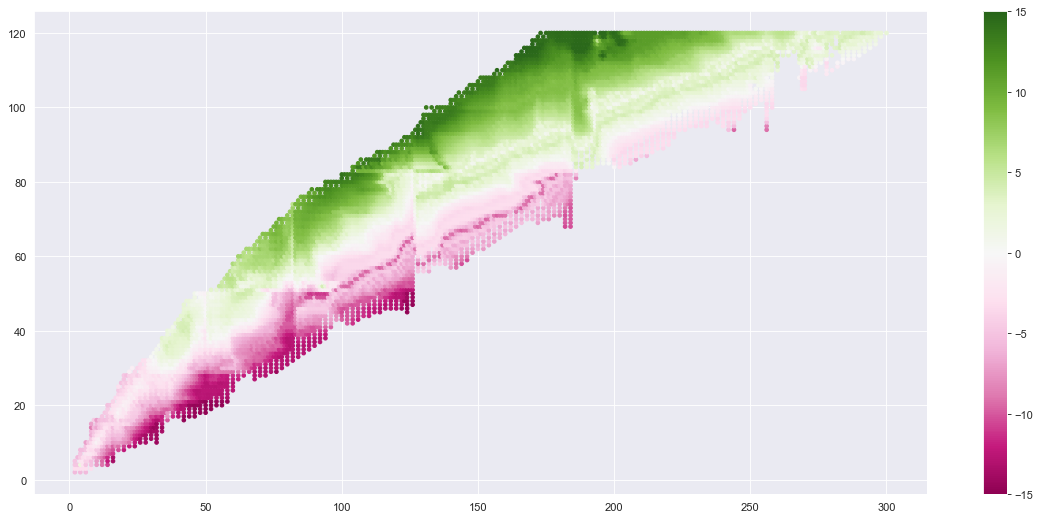

In [211]:
ext = np.int(np.ceil(max(-np.min(mean_diff_ZQ),np.max(mean_diff_ZQ))))
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
sc = plt.scatter(N_SKMS,Z_SKMS,c=mean_diff_ZQ,cmap='PiYG',vmin=-ext,vmax=ext,s=10)
plt.colorbar(sc)
plt.show()

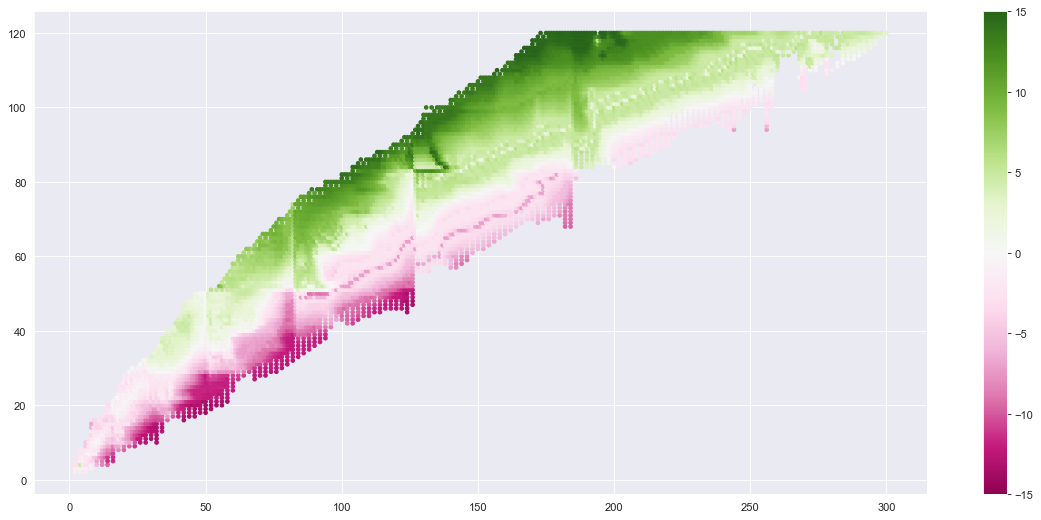

In [212]:
ext = np.int(np.ceil(max(-np.min(max_diff_ZQ),np.max(max_diff_ZQ))))
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
sc = plt.scatter(N_SKMS,Z_SKMS,c=max_diff_ZQ,cmap='PiYG',vmin=-ext,vmax=ext,s=10)
plt.colorbar(sc)
plt.show()

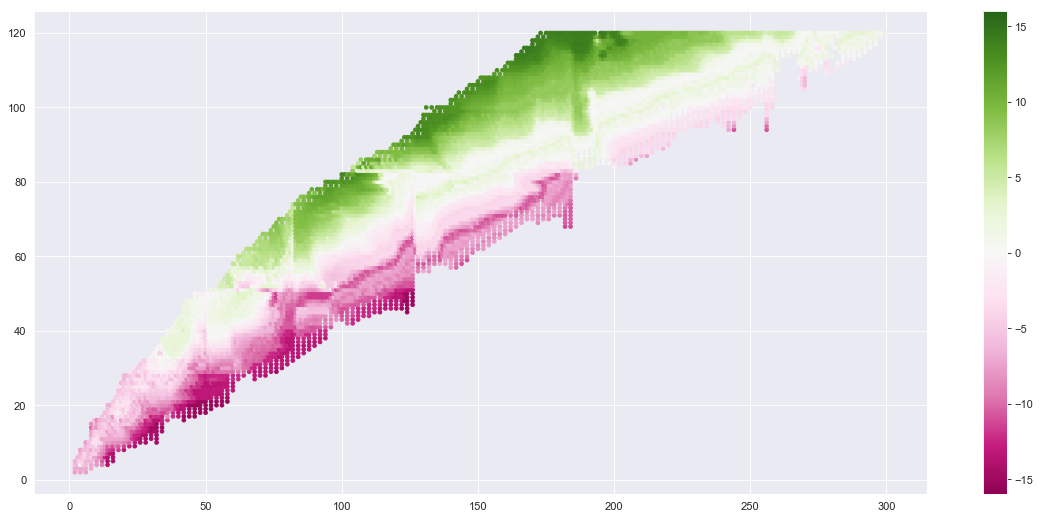

In [213]:
ext = np.int(np.ceil(max(-np.min(min_diff_ZQ),np.max(min_diff_ZQ))))
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
sc = plt.scatter(N_SKMS,Z_SKMS,c=min_diff_ZQ,cmap='PiYG',vmin=-ext,vmax=ext,s=10)
plt.colorbar(sc)
plt.show()

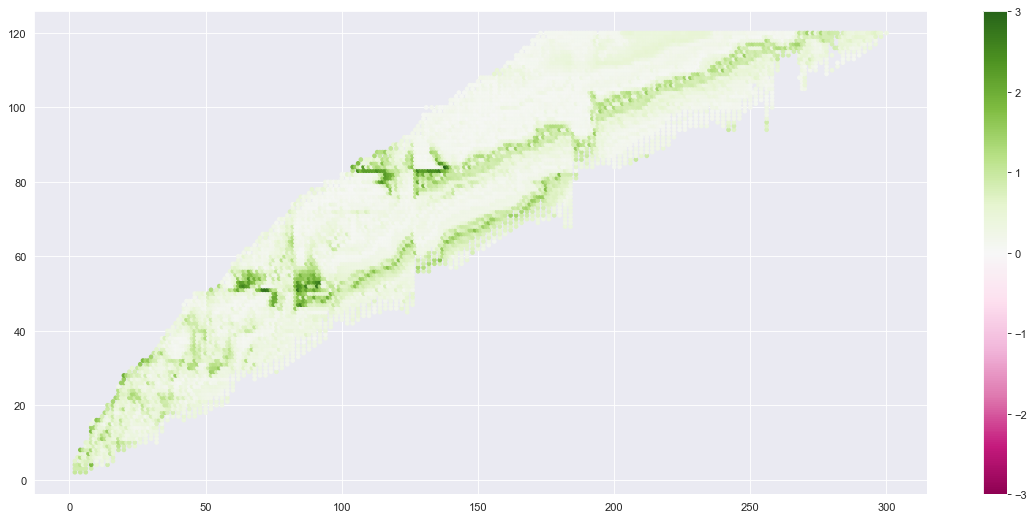

In [216]:
ext = np.int(np.ceil(max(-np.min(std_diff_ZQ),np.max(std_diff_ZQ))))
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
sc = plt.scatter(N_SKMS,Z_SKMS,c=std_diff_ZQ,cmap='PiYG',vmin=-ext,vmax=ext,s=10)
plt.colorbar(sc)
plt.show()

# Separation Energy

In [119]:
Sn_2n_SKMS_vals    =[] #n values for all SKMS theoretical values
Sn_SKMS_sep_2n     =[] #SKMS separation values WITHOUT ML

Sn_2n_SKMS_ml_vals =[]
Sn_SKMS_ml_sep_2n  =[] #SKMS separation values WITH ML

Sn_2n_exp_vals     =[] #n values for all Experimental values
Sn_exp_sep_2n      =[] #Experimental separation values 




#experimental loop
for i in range(1366,1405):
    Sn_2n_exp_vals.append(N_exp[i])
    Sn_exp_sep_2n.append(-S_2n_exp[i])
    print('N:', N_exp[i], 'S:', -S_2n_exp[i])

print('\n')
for i in range(1942, 2022):
    Sn_2n_SKMS_vals.append(N_SKMS[i])
    Sn_SKMS_sep_2n.append(-S_2n_SKMS[i])
    print('N:', N_SKMS[i], 'S:', -S_2n_SKMS[i])

print('\n')
for n in range(45, 127):
    try:
        #finding SKMS separation values with added ml component
        y_now=y_SKMS_d[50,n]+rf.predict([[50, n]])
        y_previous=y_SKMS_d[50,n-2]+rf.predict([[50, n-2]])
        #appending theoretical values and their n values to lists
        Sn_2n_SKMS_ml_vals.append(n)
        Sn_SKMS_ml_sep_2n.append(y_now-y_previous)
        print('N:', n, 'S:', y_now-y_previous)
        print('N:', n, 'prediction:', rf.predict([[50, n]]), rf.predict([[50, n-2]]) )

    except KeyError:
        continue   

plt.plot(Sn_2n_SKMS_vals,    Sn_SKMS_sep_2n, 'o')
plt.plot(Sn_2n_SKMS_ml_vals, Sn_SKMS_ml_sep_2n, 'x')
plt.plot(Sn_2n_exp_vals,     Sn_exp_sep_2n, '+')
plt.gca().legend(('SKMS without ml','SKMS with ml','Experimental values'))
plt.title('Sn 2 n separation values')
plt.xlabel('n values')
plt.ylabel('separation values')
plt.show()

N: 51.0 S: 28.551302
N: 52.0 S: 23.79446
N: 53.0 S: 22.809669
N: 54.0 S: 22.834884
N: 55.0 S: 22.507969
N: 56.0 S: 21.869284
N: 57.0 S: 21.316918
N: 58.0 S: 20.858888
N: 59.0 S: 20.260604
N: 60.0 S: 19.914654
N: 61.0 S: 19.450968
N: 62.0 S: 18.955646
N: 63.0 S: 18.532213
N: 64.0 S: 18.047308
N: 65.0 S: 17.848292
N: 66.0 S: 17.108932
N: 67.0 S: 16.506552
N: 68.0 S: 16.269438
N: 69.0 S: 15.809944
N: 70.0 S: 15.588146
N: 71.0 S: 15.27489
N: 72.0 S: 14.985614
N: 73.0 S: 14.761568
N: 74.0 S: 14.43555
N: 75.0 S: 14.222861
N: 76.0 S: 13.923694
N: 77.0 S: 13.716989
N: 78.0 S: 13.489414
N: 79.0 S: 13.262783
N: 80.0 S: 12.912768
N: 81.0 S: 12.816205
N: 82.0 S: 12.557024
N: 83.0 S: 9.751977
N: 84.0 S: 6.02981
N: 85.0 S: 5.901041
N: 86.0 S: 5.647086
N: 87.0 S: 5.270255
N: 88.0 S: 5.074
N: 89.0 S: 4.761


N: 46.0 S: 33.82244
N: 47.0 S: 33.519377
N: 48.0 S: 33.121196
N: 49.0 S: 32.112342
N: 50.0 S: 31.678933
N: 51.0 S: 27.446553
N: 52.0 S: 23.076186
N: 53.0 S: 22.861546
N: 54.0 S: 22.019101
N: 55.0 

NameError: name 'rf' is not defined